In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
path = './data/credit_fraud_datasets/creditcard_2023.csv'

In [3]:
df_original = pd.read_csv(path)
df_original.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [4]:
df_original['Class'].value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

In [15]:
df = df_original.copy()
df.shape

(568630, 31)

In [9]:
corr = df.drop(columns=['Class', 'id'], inplace=False).corr()

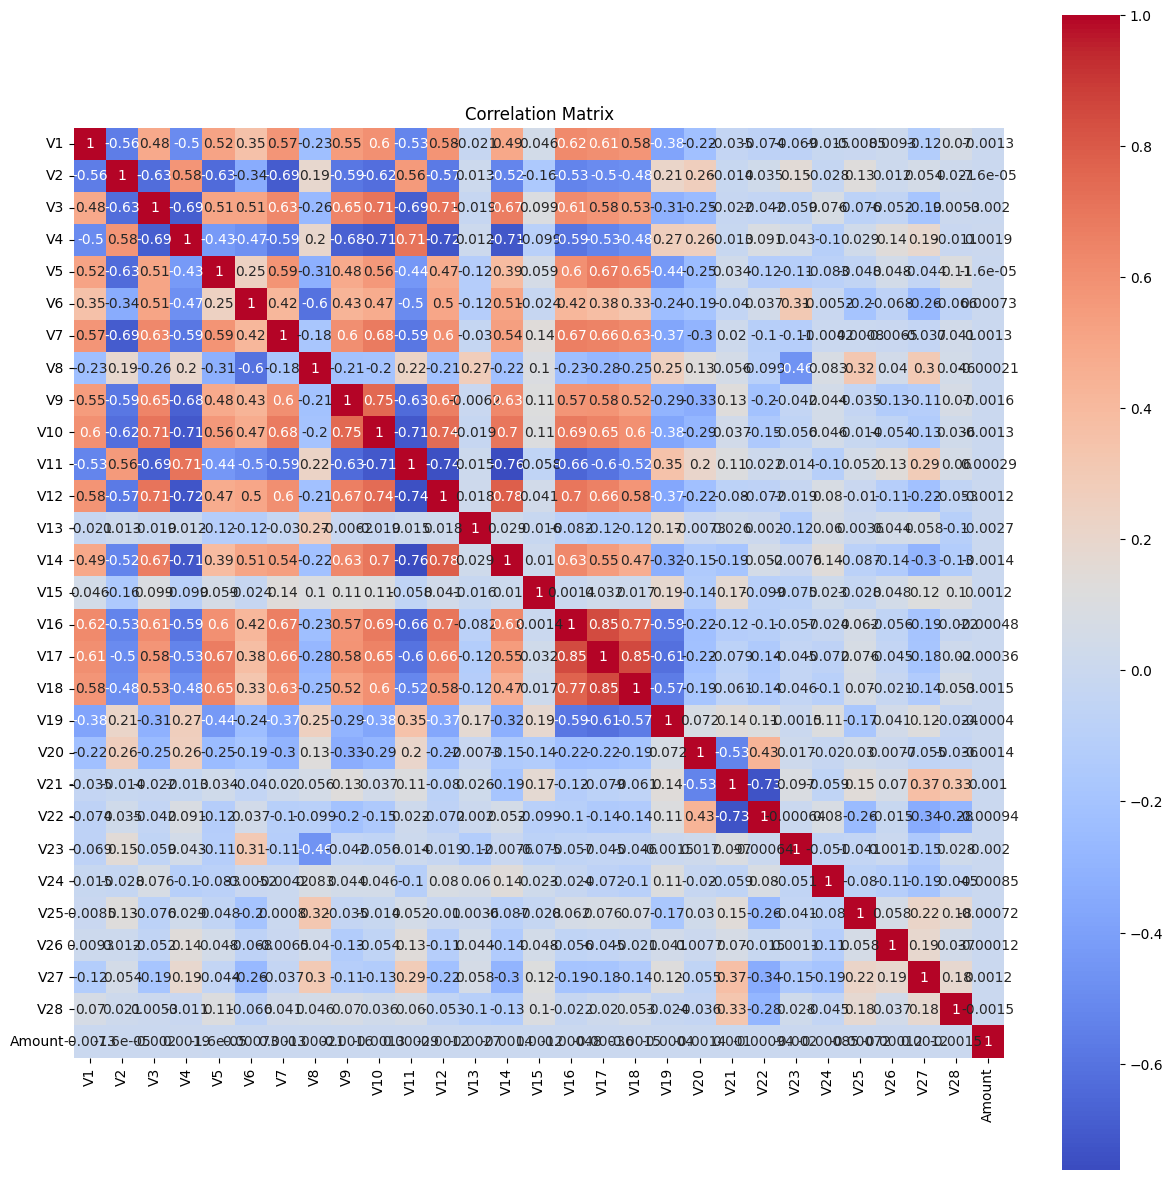

In [11]:
# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [61]:
X = df.drop('Class', axis=1)
y = df['Class']

## Splitting evaluation dataset

In [62]:
X_pre, X_eval, y_pre, y_eval = train_test_split(
    X, y, train_size=0.3, random_state=42, stratify = y)

In [65]:
X_pre.shape

(170589, 30)

In [66]:
X_eval.shape

(398041, 30)

## Splitting training and testing datasets

In [74]:
X_train, X_pool, y_train, y_pool = train_test_split(
    X_pre, y_pre, train_size=0.01, random_state=42, stratify = y_pre)

In [75]:
X_train.shape

(1705, 30)

In [76]:
X_pool.shape

(168884, 30)

In [77]:
X_train = X_train.values
y_train = y_train.values

X_pool = X_pool.values
y_pool = y_pool.values

In [78]:
# Step 2: Train an initial churn prediction model on the small labeled dataset
model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [79]:
# Step 3: Active Learning Loop
n_queries = 10  # Number of queries (customers to be labeled)

In [80]:
accuracy_list = []
f1_list = []

for _ in range(n_queries):
    # Predict probabilities on the unlabeled customer pool
    probs = model.predict_proba(X_pool)
    
    # Select the customer for which the model is most uncertain (uncertainty sampling)
    uncertainty = np.max(probs, axis=1)  # The lower the max probability, the higher the uncertainty
    query_idx = np.argmin(uncertainty)
    
    # Simulate the labeling process (e.g., manual investigation of customer data)
    X_query, y_query = X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1, )
    
    # Add the selected customer to the training set
    X_train = np.vstack([X_train, X_query])
    y_train = np.concatenate([y_train, y_query])
    
    # Remove the selected customer from the pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    
    # Retrain the churn prediction model on the updated training set
    model.fit(X_train, y_train)
    
    # Print the current training accuracy
    y_pred_train = model.predict(X_train)
    print(f"Iteration {_ + 1}, Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    accuracy_list.append(accuracy_score(y_train, y_pred_train))

    print(f"Iteration {_ + 1}, Training f1-score: {f1_score(y_train, y_pred_train):.4f}")
    f1_list.append(f1_score(y_train, y_pred_train))

    # print(classification_report(y_train, y_pred_train))

Iteration 1, Training Accuracy: 1.0000
Iteration 1, Training f1-score: 1.0000
Iteration 2, Training Accuracy: 1.0000
Iteration 2, Training f1-score: 1.0000
Iteration 3, Training Accuracy: 1.0000
Iteration 3, Training f1-score: 1.0000
Iteration 4, Training Accuracy: 1.0000
Iteration 4, Training f1-score: 1.0000
Iteration 5, Training Accuracy: 1.0000
Iteration 5, Training f1-score: 1.0000
Iteration 6, Training Accuracy: 1.0000
Iteration 6, Training f1-score: 1.0000
Iteration 7, Training Accuracy: 1.0000
Iteration 7, Training f1-score: 1.0000
Iteration 8, Training Accuracy: 1.0000
Iteration 8, Training f1-score: 1.0000
Iteration 9, Training Accuracy: 1.0000
Iteration 9, Training f1-score: 1.0000
Iteration 10, Training Accuracy: 1.0000
Iteration 10, Training f1-score: 1.0000


In [81]:
# Final accuracy on the entire dataset (for evaluation purposes)
y_pred = model.predict(X.values)
print(f"Final Accuracy on the entire dataset: {accuracy_score(y, y_pred):.4f}")

Final Accuracy on the entire dataset: 0.9997


In [82]:
print(f"Final f1 metric on the entire dataset: {f1_score(y, y_pred):.4f}")

Final f1 metric on the entire dataset: 0.9997


In [83]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       1.00      1.00      1.00    284315

    accuracy                           1.00    568630
   macro avg       1.00      1.00      1.00    568630
weighted avg       1.00      1.00      1.00    568630



## Checking unseen dataset

In [93]:
y_pred_eval = model.predict(X_eval.values)

In [94]:
y_eval_values = y_eval.values

In [95]:
print(classification_report(y_eval_values, y_pred_eval))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       1.00      1.00      1.00    199020

    accuracy                           1.00    398041
   macro avg       1.00      1.00      1.00    398041
weighted avg       1.00      1.00      1.00    398041



In [100]:
pd.DataFrame([y_eval_values, y_pred_eval]).T

,0,1
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1
...,...,...
398036,1,1
398037,1,1
398038,1,1
398039,0,0
